In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

First, we define some functions for computing the output of the multilayer perceptron.

In [2]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

Next, we define the structure and some utility functions of our multi-layer perceptron.

In [ ]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        #######################################
        #
        # TODO
        #
        #######################################
        y_oh = np.zeros(10)
        y_oh[y]=1
        grad_4 = np.matmul((self.p - y_oh), self.W4.T)

        del_3 = self.h3
        del_3[del_3>0] = 1
        del_3[del_3<0] = 0
        del_3 = np.diag(del_3)
        grad_3 = np.matmul(del_3,self.W3.T)

        del_2 = self.h2
        del_2[del_2>0] = 1
        del_2[del_2<0] = 0
        del_2 = np.diag(del_2)
        grad_2 = np.matmul(del_2,self.W2.T)

        del_1 = self.h1
        del_1[del_1>0] = 1
        del_1[del_1<0] = 0
        del_1 = np.diag(del_1)
        grad_1 = np.matmul(del_1,self.W1.T)

        grad = multi_dot([grad_4, grad_3, grad_2, grad_1])
        
        return grad

#     def attack_2(self, x, y):
        
#         grad = clf.gradient(x,y)
#         max_val = np.abs(max(grad.min(), grad.max(), key=abs))
# #         print(max_val)
#         delta_x = (grad/max_val) * self.eps
#         x = x + delta_x
        
#         return x
        
    def attack(self,x,y):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        
        #######################################
        #
        # TODO
        #
        #######################################
        grad = clf.gradient(x,y)
        max_val = np.abs(max(grad.min(), grad.max(), key=abs))
        delta_x = (grad/max_val) * self.eps
        x2 = x + delta_x
        
        delta_x = np.sign(grad) * self.eps
        x1 = x + delta_x
        
        return x1, x2

Now, let's load the pre-trained model and the test data.

In [4]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


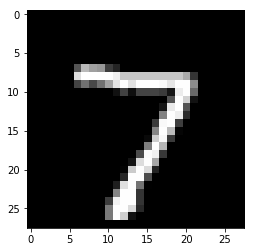

In [5]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

def disp_digit(x, y):
    print ("This is an image of Number", y)
    pixels = x.reshape((28,28))
    plt.imshow(pixels,cmap="gray")
    

Check if the model is loaded correctly. The test accuracy should be 97.6%

In [48]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


In [119]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    clf.predict(x)
#     x = clf.attack(x,y)
    x = clf.attack_2(x,y)
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.682


Test accuracy of Attack 1 is 0.335 for eps 0.05 0.335
Test accuracy of Attack 2 is 0.899 for eps 0.05 0.899
Test accuracy of Attack 1 is 0.014 for eps 0.1 0.014
Test accuracy of Attack 2 is 0.682 for eps 0.1 0.682
Test accuracy of Attack 1 is 0.002 for eps 0.15 0.002
Test accuracy of Attack 2 is 0.389 for eps 0.15 0.389
Test accuracy of Attack 1 is 0.0 for eps 0.2 0.0
Test accuracy of Attack 2 is 0.175 for eps 0.2 0.175


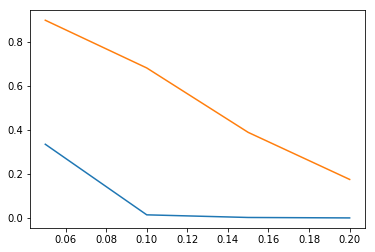

<Figure size 480x800 with 0 Axes>

In [6]:
eps_vals = [0.05, 0.1, 0.15, 0.2]
eps_error_1 =[]
eps_error_2 = []
for eps in eps_vals:
    
    clf.set_attack_budget(eps)
    nTest = 1000

    Y_pred_1 = np.zeros(nTest)
    Y_pred_2 = np.zeros(nTest)

    for i in range(nTest):
        x, y = X_test[i], Y_test[i]
        clf.predict(x)
        x1, x2 = clf.attack(x,y)
        Y_pred_1[i] = clf.predict(x1)
        Y_pred_2[i] = clf.predict(x2)

    acc = np.sum(Y_pred_1 == Y_test[:nTest])*1.0/nTest
    print (f'Test accuracy of Attack 1 is {acc} for eps {clf.eps}', acc)
    eps_error_1.append(acc)

    acc = np.sum(Y_pred_2 == Y_test[:nTest])*1.0/nTest
    print (f'Test accuracy of Attack 2 is {acc} for eps {clf.eps}', acc)
    eps_error_2.append(acc)

plt.plot(eps_vals, eps_error_1)
plt.plot(eps_vals, eps_error_2)
figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.show()

This is an image of Number 7


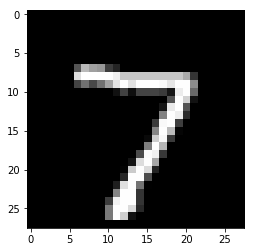

In [131]:
disp_digit(X_test[0], Y_test[0])

This is an image of Number 9


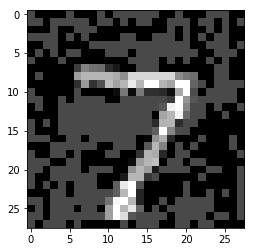

In [14]:
x, y = X_test[0], Y_test[0]
clf.predict(x)
x1, x2 = clf.attack(x,y)
y = clf.predict(x1)
disp_digit(x1, y)